# Model Calibration

This notebook is for calibrating the model. It extracts data from the yearly risk dataset created in `./pipeline.ipynb` for locations and years we have observed data on, and provides other visualization utilities. 

In [1]:
from pathlib import Path


# paths
out_dir = Path("/workspace/Shared/Tech_Projects/beetles/final_products")
yearly_risk_fp = out_dir.joinpath("yearly_risk_daymet.nc")

Define the locations and years we are interested in:

In [3]:
import numpy as np


locations_lu = {
    "Talkeetna": {
        "years": list(range(2012, 2018)),
        "latlon": (62.3209, -150.1066),
    },
    "Fairbanks": {
        "years": list(range(2014, 2020)),
        "latlon": (64.8401, -147.7200),
    },
    "King Salmon": {
        "years": list(range(2012, 2019)),
        "latlon": (58.6887, -156.6628),
    },
    "Delta Jct": {
        "years": list(range(2014, 2020)),
        "latlon": (64.0401, -145.7344),
    },
}

Define a function to extract the risk values from the dataset:

In [43]:
def latlon_to_idx(da, lat, lon):
    if da["longitude"].values.max() > 0:
        # create new longitude array for point extraction that 
        #  is on the [-360, 0) scale in case it's not
        new_lon = da["longitude"].values.copy()
        new_lon[new_lon > 0] = new_lon[new_lon > 0] - 360
    else:
        new_lon = ds["longitude"].values
    
    dist_arr = np.sqrt(
        np.square(new_lon - lon) + np.square(da["latitude"] - lat)
    ).values

    yidx, xidx = np.where(dist_arr == dist_arr.min())
    
    return yidx, xidx

In [63]:
def extract_risk_df(da, lat, lon, years):
    """Extract a dataframe of risk values for a given location"""
    yidx, xidx = latlon_to_idx(da, lat, lon)
    risk_df = da.sel(y=yidx, x=xidx, year=years).drop(["latitude", "longitude"]).to_dataframe(
        "risk"
    ).reset_index().drop(columns=["x", "y"])
    
    return risk_df

Apply the function and create a complete dataframe of extracted values for all desired locations and years:

In [64]:
import pandas as pd
import xarray as xr


with xr.open_dataset(yearly_risk_fp) as risk_ds:
    risk_df_list = []
    # start of iteration over locations
    for location in locations_lu:
        years = locations_lu[location]["years"]
        lat, lon = locations_lu[location]["latlon"]
        # ensure years are limited to daymet availability (up to 2017)
        years = [year for year in years if year <= 2017]
        temp_df = extract_risk_df(risk_ds["risk"], lat, lon, years)
        temp_df["location"] = location
        risk_df_list.append(temp_df)

risk_df = pd.concat(risk_df_list)
risk_df = risk_df[["location"] + list(risk_df.columns[:-1])]

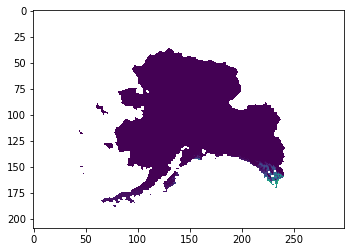

In [42]:
import matplotlib.pyplot as plt


plt.imshow(risk_ds["risk"].sel(year=1990, snow="high").values)

Define a function to extract the risk components involvied in a year's risk computation for a given location:

In [61]:
def get_components(daymet_comp_fp, year, snow, lat, lon):
    
    components = {}
    with xr.open_dataset(daymet_comp_fp) as comp_ds:
        yidx, xidx = latlon_to_idx(comp_ds, lat, lon)
        const_args = {"model": "daymet", "scenario": None, "y": yidx, "x": xidx}
        
        components["u_t2"] = comp_ds["summer_survival"].sel(year=(year - 2), **const_args).values[0][0]
        components["u_t1"] = comp_ds["summer_survival"].sel(year=(year - 1), **const_args).values[0][0]
        # "not univoltine"
        components["un_t2"] = 1 - components["u_t2"]
        components["x2_t2"] = comp_ds["fall_survival"].sel(year=(year - 2), **const_args).values[0][0]
        components["x2_t1"] = comp_ds["fall_survival"].sel(year=(year - 1), **const_args).values[0][0]
        components["x3_t2"] = comp_ds["winter_survival"].sel(year=(year - 2), snow=snow, **const_args).values[0][0]
        components["x3_t1"] = comp_ds["winter_survival"].sel(year=(year - 1), snow=snow, **const_args).values[0][0]

    return components

In [62]:
scratch_dir = Path("/atlas_scratch/kmredilla/beetles")
daymet_comp_fp = scratch_dir.joinpath("yearly_risk_components_daymet.nc")
get_components(daymet_comp_fp, 1990, "high", 65, -147)

{'u_t2': 1.0,
 'u_t1': 0.89,
 'un_t2': 0.0,
 'x2_t2': 0.0,
 'x2_t1': 0.0,
 'x3_t2': 1.0,
 'x3_t1': 0.62}

## Profiling

Set up some sort of structure for profiling the weights, i.e. for re-processing the risk dataset with different weights programmatically.

In [103]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix